# Procesamiento de Imágenes
## Trabajo Practico 4 - Análisis frecuencial

In [27]:
import cv2
from PIL import Image
import os   
import numpy as np
import matplotlib.pyplot as plt

img_high = cv2.imread('./img/city.jpg')
img_low = cv2.imread('./img/beach.jpg')

img_high = cv2.cvtColor(img_high, cv2.COLOR_BGR2GRAY)
img_low = cv2.cvtColor(img_low, cv2.COLOR_BGR2GRAY)

# Resize to the same size
width = 768
height = 1440

img_high = cv2.resize(img_high, (width, height))
img_low = cv2.resize(img_low, (width, height))

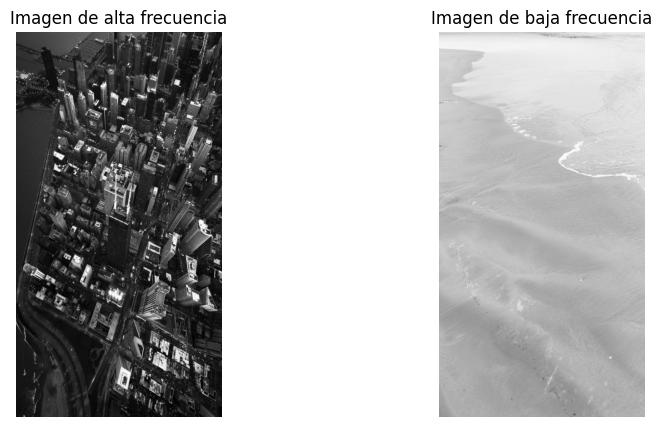

In [ ]:
# mostrar las imagenes
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_high, cmap='gray')
plt.suptitle('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_low, cmap='gray')
plt.suptitle('Imagen de baja frecuencia')
plt.axis('off')
plt.show()

### 10. (*) Responder las siguientes preguntas. Tratar de utilizar dos imágenes en aquellos ejercicios que no soliciten algo particular. Utilizar una imagen que muestre frecuencias bajas en su mayoría y otras con mayoría de frecuencias altas. Por cada pregunta se ha agregado una sugerencia de como realizar el ejercicio practico para acompañar su respuesta

#### (a) ¿Cómo se visualiza la diferencia entre las frecuencias altas y bajas en una imagen? Ejercicio sugerido: Aplicar la Transformada de Fourier (DFT) y mostrar la magnitud del espectro centrado con fftshift

In [29]:
# Helper
def normalize(img):
    img = img - img.min()
    return img / img.max()


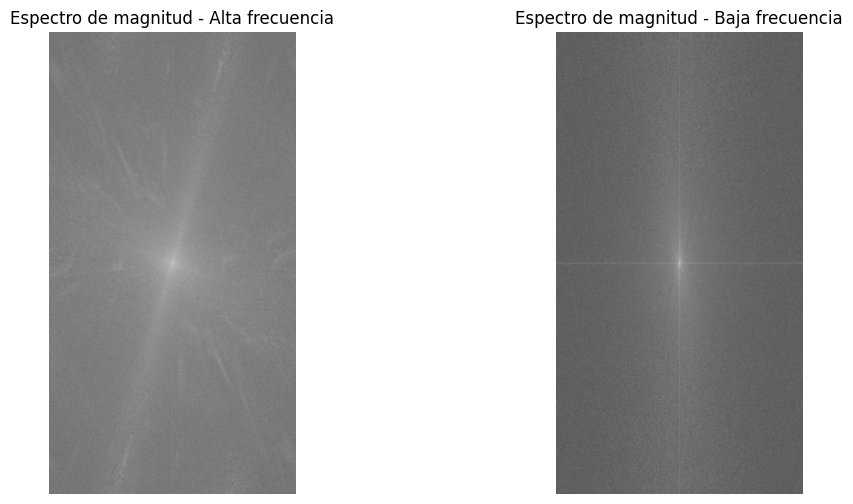

In [ ]:
# Fourier analysis
fourier_high = np.fft.fft2(img_high)
fourier_low = np.fft.fft2(img_low)

# Shift the zero frequency component to the center
fourier_high_shifted = np.fft.fftshift(fourier_high)
fourier_low_shifted = np.fft.fftshift(fourier_low)

# Calculate the magnitude spectrum
mag_high = np.abs(fourier_high_shifted) 
mag_low = np.abs(fourier_low_shifted)

spect_high = np.log(mag_high)/ 20
spect_low = np.log(mag_low)/ 20



# Use same scale for both to highlight differences
vmin = 0
vmax = max(spect_high.max(), spect_low.max())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(spect_high, cmap='gray', vmin=vmin, vmax=vmax)
plt.suptitle('Espectro de magnitud - Alta frecuencia')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spect_low, cmap='gray', vmin=vmin, vmax=vmax)
plt.suptitle('Espectro de magnitud - Baja frecuencia')
plt.axis('off')

plt.show()

#### ¿Qué ocurre si eliminamos las componentes de alta frecuencia de una imagen? ¿Y si eliminamos las de baja frecuencia? Ejercicio sugerido: Aplicar filtros pasa bajos y pasa altos en el dominio de la frecuencia y reconstruir la imagen con la transformada inversa

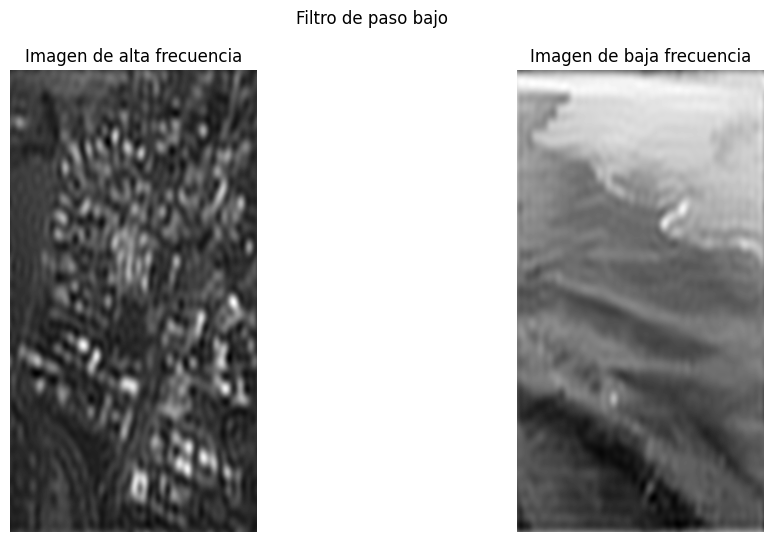

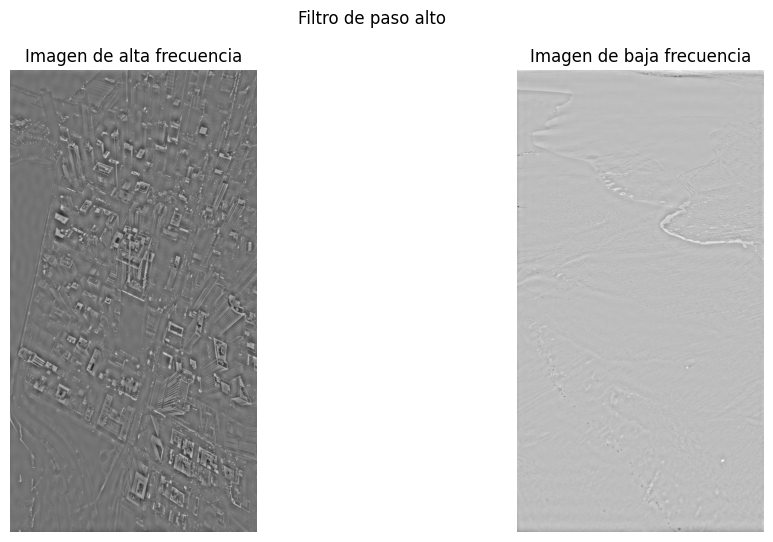

In [37]:
## Flitros de alta y baja frecuencia en analisis de Fourier
def low_pass_filter(shape, radius):
    mask = np.zeros(shape, dtype=np.float32)
    cy, cx = shape[0] // 2, shape[1] // 2
    cv2.circle(mask, (cx, cy), radius, 1, thickness=-1)[0]
    cv2.GaussianBlur(mask, (0, 0), 10)

    return mask

def high_pass_filter(shape, radius):
    low_pass = low_pass_filter(shape, radius)
    return 1 - low_pass

def apply_filter(fourier, mask):
    return fourier * mask

def inverse_transform(fourier):
    return np.fft.ifft2(np.fft.ifftshift(fourier)).real




hpf_high = apply_filter(fourier_high_shifted, high_pass_filter(img_high.shape, 30))
lpf_high = apply_filter(fourier_high_shifted, low_pass_filter(img_high.shape, 30))
hpf_low = apply_filter(fourier_low_shifted, high_pass_filter(img_low.shape, 30))
lpf_low = apply_filter(fourier_low_shifted, low_pass_filter(img_low.shape, 30))

# inversas
img_high_hpf = inverse_transform(hpf_high)
img_high_lpf = inverse_transform(lpf_high)

img_low_hpf = inverse_transform(hpf_low)
img_low_lpf = inverse_transform(lpf_low)


# show
plt.figure(figsize=(12, 6))
plt.suptitle('Filtro de paso bajo')
plt.subplot(1, 2, 1)
plt.imshow(img_high_lpf, cmap='gray')
plt.title('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_low_lpf, cmap='gray')
plt.title('Imagen de baja frecuencia')
plt.axis('off')
plt.show()


plt.figure(figsize=(12, 6))
plt.suptitle('Filtro de paso alto')
plt.subplot(1, 2, 1)
plt.imshow(img_high_hpf, cmap='gray')
plt.title('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_low_hpf, cmap='gray')
plt.title('Imagen de baja frecuencia')
plt.axis('off')
plt.show()


#### ¿Qué representa la fase de la transformada de Fourier de una imagen? ¿Qué ocurre si se conserva solo la fase o solo la magnitud? Ejercicio sugerido: Reconstruir una imagen usando solo la magnitud y fase de otra imagen, intercambiar fase y magnitud entre dos imágenes distintas.

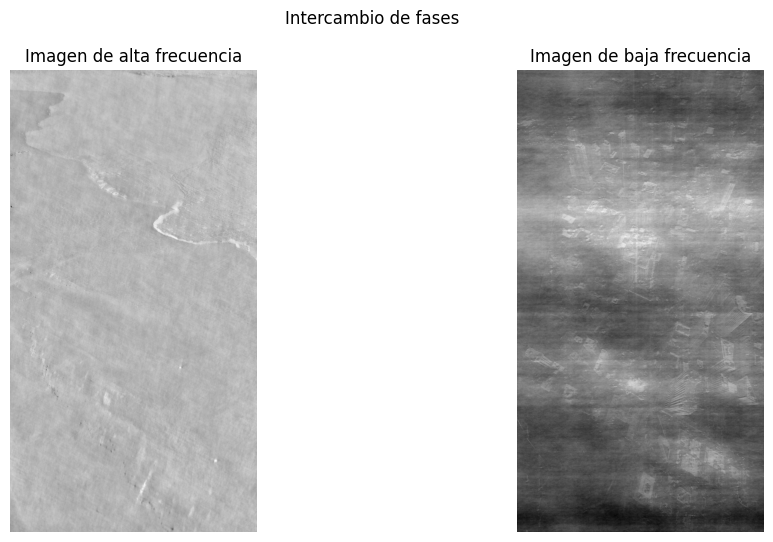

In [38]:
fase_high = np.angle(fourier_high_shifted)
fase_low = np.angle(fourier_low_shifted)

# intercambiar fases y reconstruir usando la inversa
fourier_high_shifted_new = mag_high * np.exp(1j * fase_low)
fourier_low_shifted_new = mag_low * np.exp(1j * fase_high)
img_high_new = inverse_transform(fourier_high_shifted_new)
img_low_new = inverse_transform(fourier_low_shifted_new)
plt.figure(figsize=(12, 6))
plt.suptitle('Intercambio de fases')
plt.subplot(1, 2, 1)
plt.imshow(img_high_new, cmap='gray')
plt.title('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_low_new, cmap='gray')
plt.title('Imagen de baja frecuencia')
plt.axis('off')
plt.show()


#### Por qué se centra la transformada de Fourier para su visualizaci´on? ¿Qu´e efecto tiene? Ejercicio sugerido: Mostrar el espectro de magnitud con y sin aplicar fftshift

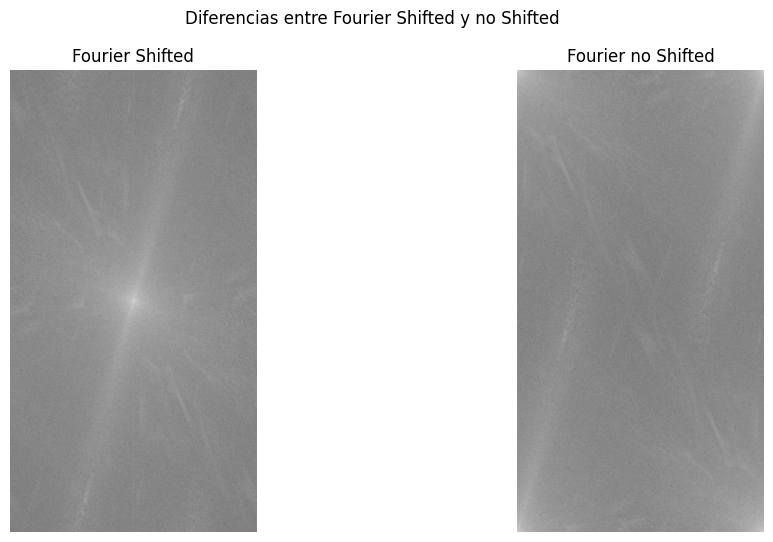

In [41]:
shifted = fourier_high_shifted
unshifted = fourier_high

# Mostrar las diferencias entre las dos
plt.figure(figsize=(12, 6))
plt.suptitle('Diferencias entre Fourier Shifted y no Shifted')
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(shifted)) / 20, cmap='gray')
plt.title('Fourier Shifted')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.log(np.abs(unshifted)) / 20, cmap='gray')
plt.title('Fourier no Shifted')
plt.axis('off')
plt.show()

#### (e) ¿Cómo se comporta la transformada de Fourier ante la traslación o rotación de una imagen? Ejercicio sugerido: Aplicar una traslación o rotación y comparar los espectros de magnitud y fase antes y después.

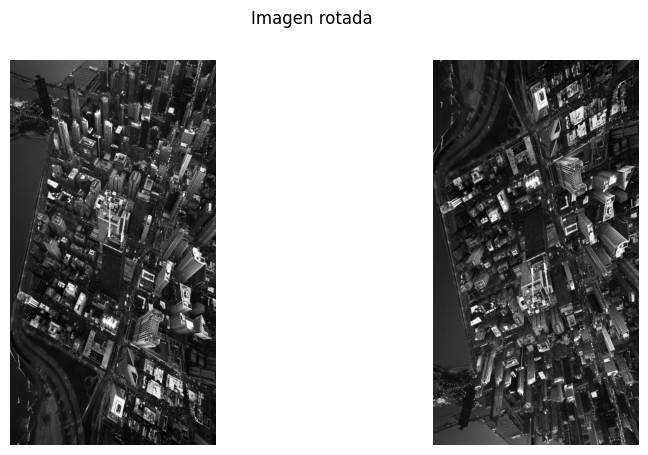

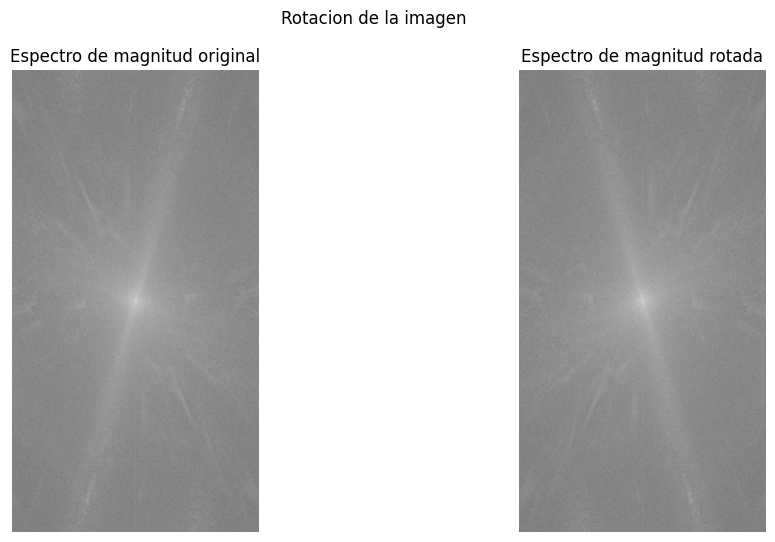

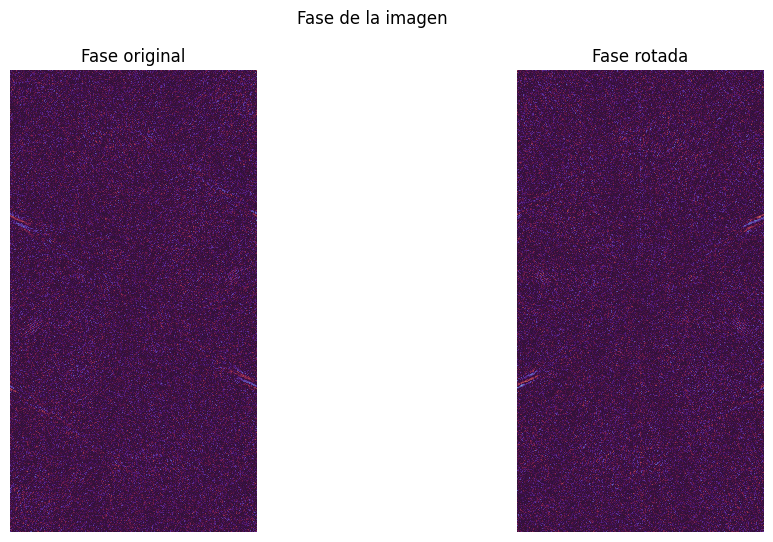

In [45]:
mag_original = mag_high
fase_original = np.angle(fourier_high_shifted)


# Trasladar la imagen: invertida con respecto al eje x
img_rotated = cv2.flip(img_high, 0)

img_rotated = cv2.resize(img_rotated, (width, height))
# Mostrar la imagen rotada
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_high, cmap='gray')
plt.suptitle('Imagen original')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_rotated, cmap='gray')    
plt.suptitle('Imagen rotada')
plt.axis('off')
plt.show()

# Transformada de Fourier
fourier_rotated = np.fft.fft2(img_rotated)
fourier_rotated_shifted = np.fft.fftshift(fourier_rotated)
mag_rotated = np.abs(fourier_rotated_shifted)
fase_rotated = np.angle(fourier_rotated_shifted)


# normalizar y mostrar
plt.figure(figsize=(12, 6))
plt.suptitle('Rotacion de la imagen')
plt.subplot(1, 2, 1)
plt.imshow(np.log(mag_original) / 20, cmap='gray')
plt.title('Espectro de magnitud original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.log(mag_rotated) / 20, cmap='gray')
plt.title('Espectro de magnitud rotada')
plt.axis('off')
plt.show()


# mostrar la fase
plt.figure(figsize=(12, 6))
plt.suptitle('Fase de la imagen')
plt.subplot(1, 2, 1)
plt.imshow(fase_original, cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.title('Fase original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(fase_rotated, cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.title('Fase rotada')
plt.axis('off')
plt.show()